In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
# Define the paths for data

train_data_path = r"train"
test_data_path = r"test"

In [3]:
# Check if train data path is correct
train_data_path = r"train"
if os.path.exists(train_data_path):
    print("Training data path exists. Contents:")
    print(os.listdir(train_data_path))
else:
    print("Training data path does not exist.")

# Check if test data path is correct
test_data_path = r"test"
if os.path.exists(test_data_path):
    print("Test data path exists. Contents:")
    print(os.listdir(test_data_path))
else:
    print("Test data path does not exist.")

Training data path exists. Contents:
['0', '1', '2', '3']
Test data path exists. Contents:
['0', '1', '2', '3']


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are in grayscale
    transforms.Resize((48, 48)),                  # Resize images if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))          # Normalize based on grayscale values
])

In [5]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.categories = {0: 'Angry', 1: 'Disgust', 2: 'Sad', 3: 'Fear'}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = np.fromstring(self.data.iloc[idx, 1], dtype=int, sep=' ').reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img)
        label = int(self.data.iloc[idx, 0])

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
# Define batch size
batch_size = 64

# Create datasets
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
#inverse transformtion for denormalization
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.5 / 0.5], std=[1 / 0.5])  # Undo normalization
])

In [8]:
#function to display images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = inverse_transform(img)  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

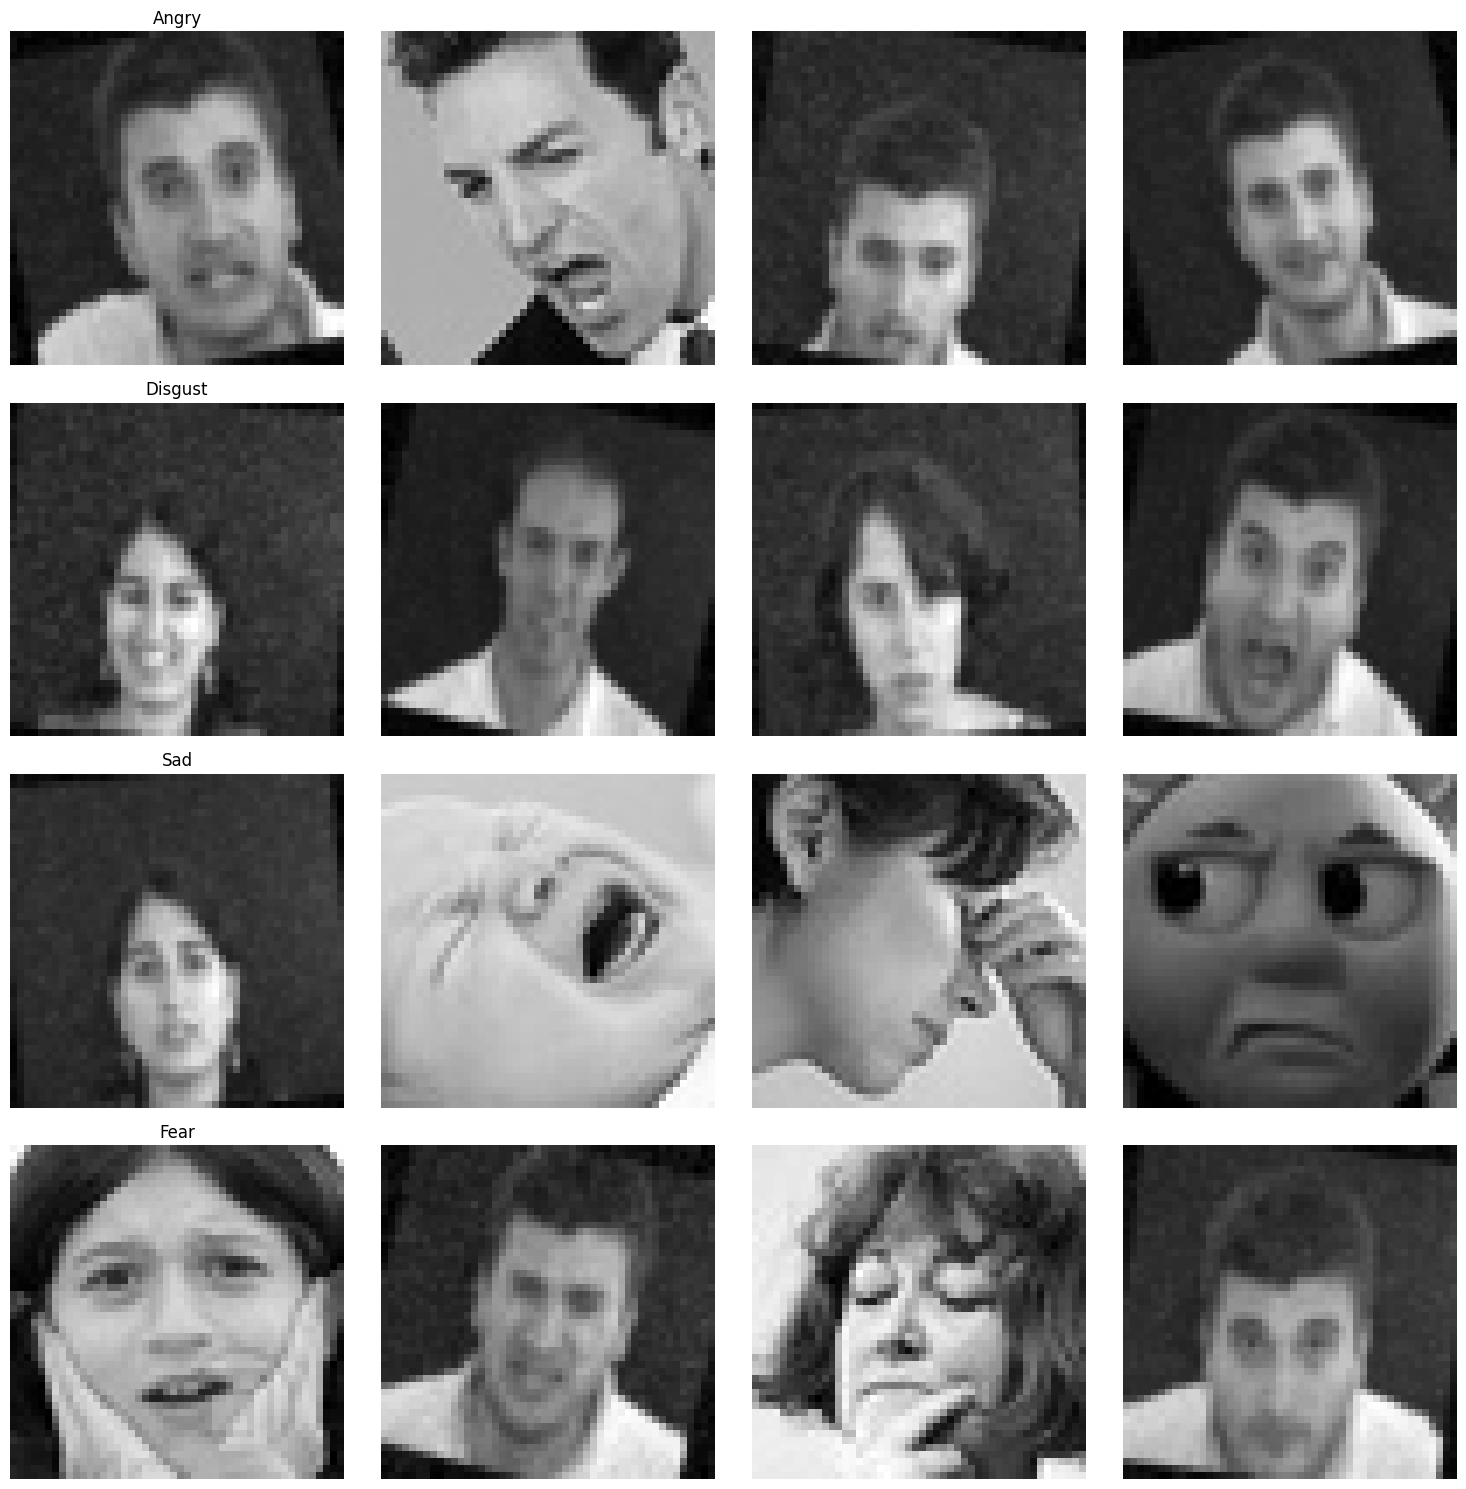

In [9]:
#visualize some sample images

# Define categories 
categories = {0: 'Angry', 1: 'Disgust', 2: 'Sad', 3: 'Fear'}

# Function to plot images
def plot_samples(data_loader, categories, samples_per_category=4):
    fig, axes = plt.subplots(len(categories), samples_per_category, figsize=(15, 15))
    data_iter = iter(data_loader)
    samples_drawn = {category: 0 for category in categories}
    while any(samples_drawn[cat] < samples_per_category for cat in samples_drawn):
        images, labels = next(data_iter)
        for img, label in zip(images, labels):
            if samples_drawn[label.item()] < samples_per_category:
                ax = axes[label.item(), samples_drawn[label.item()]]
                img = inverse_transform(img)  # Denormalize
                npimg = img.numpy()
                ax.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
                ax.axis('off')
                if samples_drawn[label.item()] == 0:
                    ax.set_title(categories[label.item()])
                samples_drawn[label.item()] += 1
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_samples(train_loader, categories)

In [10]:
#define neural network model using pytorch through tourch.nn module
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Define the fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Define dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # Apply the first convolutional layer and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply the second convolutional layer and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Apply the third convolutional layer and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor
        x = x.view(-1, 128 * 6 * 6)

        # Apply the first fully connected layer with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Apply the second fully connected layer (output layer)
        x = self.fc2(x)

        return x

# Create an instance of the model
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4  # Based on the categories in the dataset
model = EmotionCNN(num_classes=num_classes).to(device)

# Print the model architecture
print(model)

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [11]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training the model

# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if (i + 1) % 200 == 0:  # Print every 200 batches
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

# Track training loss and accuracy
train_losses = []
train_accuracies = []

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0  # Reset running loss and accuracy for each epoch
    running_acc = 0.0

    train(model, device, train_loader, criterion, optimizer, epoch)

    # Append the average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

Epoch 1, Batch 200, Loss: 1.2377, Accuracy: 0.3784
Epoch 2, Batch 200, Loss: 0.9910, Accuracy: 0.5377
Epoch 3, Batch 200, Loss: 0.8460, Accuracy: 0.6171
Epoch 4, Batch 200, Loss: 0.7573, Accuracy: 0.6639
Epoch 5, Batch 200, Loss: 0.6800, Accuracy: 0.7023
Epoch 6, Batch 200, Loss: 0.6011, Accuracy: 0.7430
Epoch 7, Batch 200, Loss: 0.5312, Accuracy: 0.7701
Epoch 8, Batch 200, Loss: 0.4650, Accuracy: 0.8059
Epoch 9, Batch 200, Loss: 0.4119, Accuracy: 0.8298
Epoch 10, Batch 200, Loss: 0.3622, Accuracy: 0.8503


In [13]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)

            # Store predictions and labels for further analysis
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy over the test set
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}')
    return all_preds, all_labels

In [14]:
# Evaluate the model on the test dataset
# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)

Test Loss: 0.9889, Test Accuracy: 0.6243


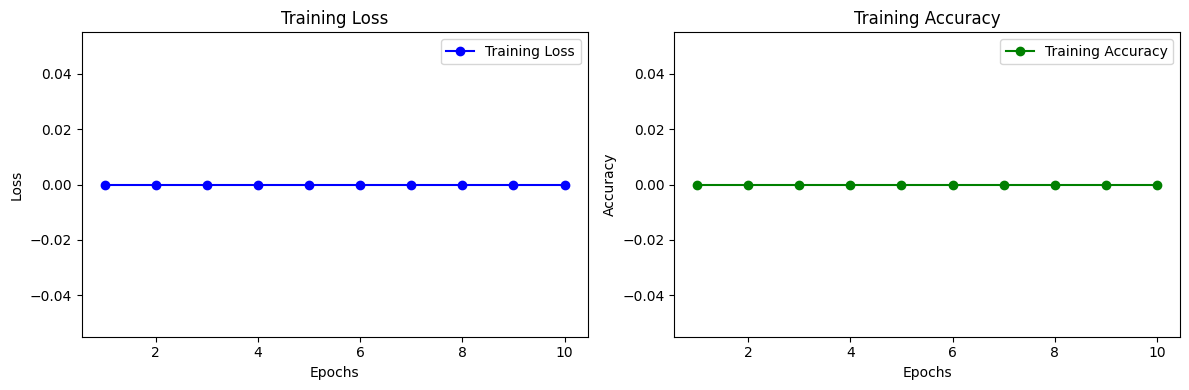

In [15]:
# Plot training loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

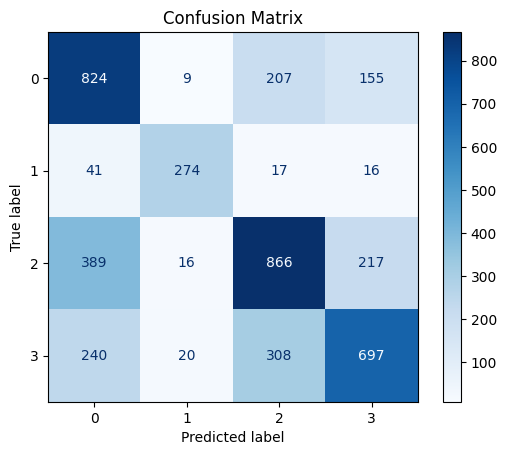

In [16]:
# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_dataset.classes))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [17]:
model = torch.load('model.pth')